In [2]:
import torch

In [4]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CustomImageDataset(Dataset):
    """Кастомный датасет для работы с папками классов"""
    
    def __init__(self, root_dir: str, transform=None, target_size: tuple =(224, 224)):
        """
        Args:
            root_dir (str): Путь к папке с классами
            transform: Аугментации для изображений
            target_size (tuple): Размер для ресайза изображений
        """
        self.root_dir = root_dir
        self.transform = transform
        self.target_size = target_size
        
        # Получаем список классов (папок)
        self.classes = sorted([d for d in os.listdir(root_dir) 
                              if os.path.isdir(os.path.join(root_dir, d))])
        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(self.classes)}
        
        # Собираем все пути к изображениям
        self.images = []
        self.labels = []
        
        for class_name in self.classes:
            class_dir = os.path.join(root_dir, class_name)
            class_idx = self.class_to_idx[class_name]
            
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                    img_path = os.path.join(class_dir, img_name)
                    self.images.append(img_path)
                    self.labels.append(class_idx)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Загружаем изображение
        image = Image.open(img_path).convert('RGB')
        
        # Ресайзим изображение
        image = image.resize(self.target_size, Image.Resampling.LANCZOS)
        
        # Применяем аугментации
        if self.transform:
            image = self.transform(image)
        
        return image, label
    
    def get_class_names(self):
        """Возвращает список имен классов"""
        return self.classes 

In [6]:
from matplotlib import transforms
import torch
import random
import numpy as np
import cv2
from PIL import Image, ImageEnhance, ImageOps


class AddGaussianNoise:
    """Добавляет гауссов шум к изображению."""
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean


class RandomErasingCustom:
    """Случайно затирает прямоугольную область изображения."""
    def __init__(self, p=0.5, scale=(0.02, 0.2)):
        self.p = p
        self.scale = scale
    def __call__(self, img):
        if random.random() > self.p:
            return img
        c, h, w = img.shape
        area = h * w
        erase_area = random.uniform(*self.scale) * area
        erase_w = int(np.sqrt(erase_area))
        erase_h = int(erase_area // erase_w)
        x = random.randint(0, w - erase_w)
        y = random.randint(0, h - erase_h)
        img[:, y:y+erase_h, x:x+erase_w] = 0
        return img


class CutOut:
    """Вырезает случайную прямоугольную область из изображения."""
    def __init__(self, p=0.5, size=(16, 16)):
        self.p = p
        self.size = size
    def __call__(self, img):
        if random.random() > self.p:
            return img
        c, h, w = img.shape
        cut_h, cut_w = self.size
        x = random.randint(0, w - cut_w)
        y = random.randint(0, h - cut_h)
        img[:, y:y+cut_h, x:x+cut_w] = 0
        return img


class Solarize:
    """Инвертирует пиксели выше порога."""
    def __init__(self, threshold=128):
        self.threshold = threshold
    def __call__(self, img):
        img_np = img.numpy()
        mask = img_np > self.threshold / 255.0
        img_np[mask] = 1.0 - img_np[mask]
        return torch.from_numpy(img_np)


class Posterize:
    """Уменьшает количество бит на канал."""
    def __init__(self, bits=4):
        self.bits = bits
    def __call__(self, img):
        img_np = img.numpy()
        factor = 2 ** (8 - self.bits)
        img_np = (img_np * 255).astype(np.uint8)
        img_np = (img_np // factor) * factor
        return torch.from_numpy(img_np.astype(np.float32) / 255.0)


class AutoContrast:
    """Автоматически улучшает контраст изображения."""
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, img):
        if random.random() > self.p:
            return img
        img_np = img.numpy().transpose(1, 2, 0)
        img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
        img_pil = ImageOps.autocontrast(img_pil)
        img_np = np.array(img_pil).astype(np.float32) / 255.0
        return torch.from_numpy(img_np.transpose(2, 0, 1))


class ElasticTransform:
    """Эластичная деформация изображения."""
    def __init__(self, p=0.5, alpha=1, sigma=50):
        self.p = p
        self.alpha = alpha
        self.sigma = sigma
    def __call__(self, img):
        if random.random() > self.p:
            return img
        img_np = img.numpy().transpose(1, 2, 0)
        h, w = img_np.shape[:2]
        
        # Создаем случайные смещения
        dx = np.random.randn(h, w) * self.alpha
        dy = np.random.randn(h, w) * self.alpha
        
        # Сглаживаем смещения
        dx = cv2.GaussianBlur(dx, (0, 0), self.sigma)
        dy = cv2.GaussianBlur(dy, (0, 0), self.sigma)
        
        # Применяем деформацию
        x, y = np.meshgrid(np.arange(w), np.arange(h))
        x = x + dx
        y = y + dy
        
        # Нормализуем координаты
        x = np.clip(x, 0, w - 1)
        y = np.clip(y, 0, h - 1)
        
        # Применяем трансформацию
        img_deformed = cv2.remap(img_np, x.astype(np.float32), y.astype(np.float32), 
                                cv2.INTER_LINEAR)
        return torch.from_numpy(img_deformed.transpose(2, 0, 1))


class MixUp:
    """Смешивает два изображения."""
    def __init__(self, p=0.5, alpha=0.2):
        self.p = p
        self.alpha = alpha
    def __call__(self, img1, img2):
        if random.random() > self.p:
            return img1
        lam = np.random.beta(self.alpha, self.alpha)
        return lam * img1 + (1 - lam) * img2 


class RandomBlur:
    """Случайное размытие изображения"""
    def __init__(self, p=0.5, kernel_size=5):
        self.p = p
        self.kernel_size = kernel_size
    
    def __call__(self, img):
        if random.random() < self.p:
            # Конвертируем тензор в numpy
            img_np = img.numpy().transpose(1, 2, 0)
            # Применяем размытие
            blurred = cv2.GaussianBlur(img_np, (self.kernel_size, self.kernel_size), 0)
            return torch.from_numpy(blurred.transpose(2, 0, 1))
        return img


class RandomPerspective:
    """Случайная перспективная трансформация"""
    def __init__(self, p=0.5, distortion_scale=0.5):
        self.p = p
        self.distortion_scale = distortion_scale
    
    def __call__(self, img):
        if random.random() < self.p:
            # Конвертируем тензор в PIL
            to_pil = transforms.ToPILImage()
            img_pil = to_pil(img)
            
            # Параметры перспективы
            w, h = img_pil.size
            half_w = w // 2
            half_h = h // 2
            
            # Генерируем случайные смещения
            dx = random.randint(0, int(self.distortion_scale * half_w))
            dy = random.randint(0, int(self.distortion_scale * half_h))
            
            # Точки для перспективной трансформации
            src_points = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
            dst_points = np.float32([
                [dx, dy], 
                [w - dx, dy], 
                [0, h], 
                [w, h]
            ])
            
            # Применяем перспективную трансформацию
            M = cv2.getPerspectiveTransform(src_points, dst_points)
            img_np = np.array(img_pil)
            transformed = cv2.warpPerspective(img_np, M, (w, h))
            
            return transforms.ToTensor()(transformed)
        return img

class RandomBrightnessContrast:
    """Случайное изменение яркости и контрастности"""
    def __init__(self, p=0.5, brightness_range=(0.7, 1.3), contrast_range=(0.7, 1.3)):
        self.p = p
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
    
    def __call__(self, img):
        if random.random() < self.p:
            # Конвертируем тензор в PIL
            to_pil = transforms.ToPILImage()
            img_pil = to_pil(img)
            
            # Изменяем яркость
            brightness_factor = random.uniform(*self.brightness_range)
            enhancer = ImageEnhance.Brightness(img_pil)
            img_pil = enhancer.enhance(brightness_factor)
            
            # Изменяем контраст
            contrast_factor = random.uniform(*self.contrast_range)
            enhancer = ImageEnhance.Contrast(img_pil)
            img_pil = enhancer.enhance(contrast_factor)
            
            return transforms.ToTensor()(img_pil)
        return img

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms
from PIL import Image

def _ensure_tensor(img):
    """Конвертирует PIL.Image в тензор при необходимости"""
    if isinstance(img, Image.Image):
        return transforms.ToTensor()(img)
    return img


def show_image(image, label=None, title=None, size=128):
    """Визуализирует одно изображение."""
    # Конвертируем изображение в тензор
    image = _ensure_tensor(image)
    
    # Ресайз изображения
    resize_transform = transforms.Resize((size, size), antialias=True)
    image_resized = resize_transform(image)
    
    # Преобразуем тензор в numpy array и меняем порядок размерностей
    img_np = image_resized.numpy().transpose(1, 2, 0)
    img_np = np.clip(img_np, 0, 1)  # Обеспечиваем корректный диапазон значений
    
    # Создаем фигуру и оси
    plt.figure(figsize=(4, 4))
    plt.imshow(img_np)
    plt.axis('off')  # Скрываем оси
    
    # Добавляем заголовки при необходимости
    if label is not None:
        plt.title(f'Label: {label}', fontsize=12)
    if title:
        plt.suptitle(title, fontsize=14)
    
    plt.tight_layout()
    plt.show()


def show_images(images, labels=None, nrow=8, title=None, size=128):
    """Визуализирует батч изображений."""
    # Конвертируем все изображения в тензоры
    images = [_ensure_tensor(img) for img in images]
    images = images[:nrow]
    
    # Ресайз изображений
    resize_transform = transforms.Resize((size, size), antialias=True)
    images_resized = [resize_transform(img) for img in images]
    
    # Визуализация
    fig, axes = plt.subplots(1, nrow, figsize=(nrow*2, 2))
    if nrow == 1:
        axes = [axes]
    
    for i, img in enumerate(images_resized):
        img_np = img.numpy().transpose(1, 2, 0)
        img_np = np.clip(img_np, 0, 1)
        axes[i].imshow(img_np)
        axes[i].axis('off')
        if labels is not None:
            axes[i].set_title(f'Label: {labels[i]}')
    
    if title:
        fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def show_single_augmentation(original_img, augmented_img, title="Аугментация"):
    """Визуализирует оригинальное и аугментированное изображение рядом."""
    # Конвертируем в тензоры
    original_img = _ensure_tensor(original_img)
    augmented_img = _ensure_tensor(augmented_img)
    
    # Ресайз
    resize_transform = transforms.Resize((128, 128), antialias=True)
    orig_resized = resize_transform(original_img)
    aug_resized = resize_transform(augmented_img)
    
    # Визуализация
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    
    orig_np = orig_resized.numpy().transpose(1, 2, 0)
    orig_np = np.clip(orig_np, 0, 1)
    ax1.imshow(orig_np)
    ax1.set_title("Оригинал")
    ax1.axis('off')
    
    aug_np = aug_resized.numpy().transpose(1, 2, 0)
    aug_np = np.clip(aug_np, 0, 1)
    ax2.imshow(aug_np)
    ax2.set_title(title)
    ax2.axis('off')
    
    plt.tight_layout()
    plt.show()


def show_multiple_augmentations(original_img, augmented_imgs, titles, max_per_row=4):
    """
    Визуализирует оригинальное изображение и несколько аугментаций
    с автоматическим разбиением на строки (максимум max_per_row в строке)
    """
    # Конвертируем в тензоры
    original_img = _ensure_tensor(original_img)
    augmented_imgs = [_ensure_tensor(img) for img in augmented_imgs]
    
    # Собираем все изображения
    all_imgs = [original_img] + augmented_imgs
    all_titles = ["Оригинал"] + titles
    
    # Рассчитываем количество строк и столбцов
    n_total = len(all_imgs)
    n_rows = (n_total + max_per_row - 1) // max_per_row
    n_cols = min(n_total, max_per_row)
    
    # Создаем фигуру с сеткой подграфиков
    fig, axs = plt.subplots(
        n_rows, 
        n_cols, 
        figsize=(n_cols * 3, n_rows * 3)
    )
    
    # Если только одна строка, делаем axs итерируемым
    if n_rows == 1:
        axs = [axs]
    
    # Ресайз изображений
    resize_transform = transforms.Resize((192, 192), antialias=True)
    
    # Визуализируем изображения
    for i in range(n_rows):
        row_start = i * max_per_row
        row_end = min((i + 1) * max_per_row, n_total)
        row_items = row_end - row_start
        
        for j in range(row_items):
            idx = row_start + j
            img = all_imgs[idx]
            title = all_titles[idx]
            
            # Получаем ось для текущего изображения
            if n_rows > 1:
                ax = axs[i][j] if row_items > 1 else axs[i]
            else:
                ax = axs[j] if row_items > 1 else axs
            
            # Ресайзим изображение
            img_resized = resize_transform(img)
            img_np = img_resized.numpy().transpose(1, 2, 0)
            img_np = np.clip(img_np, 0, 1)
            
            ax.imshow(img_np)
            ax.set_title(title, fontsize=10)
            ax.axis('off')
    
    # Скрываем пустые подграфики
    if n_total % max_per_row != 0:
        empty_cells = max_per_row - (n_total % max_per_row)
        for j in range(row_items, row_items + empty_cells):
            if n_rows > 1:
                axs[-1][j].axis('off')
            else:
                axs[j].axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.suptitle(f"Сравнение аугментаций ({n_total} изображений)", fontsize=14)
    plt.show()

Оригинальное изображение, класс: abrams


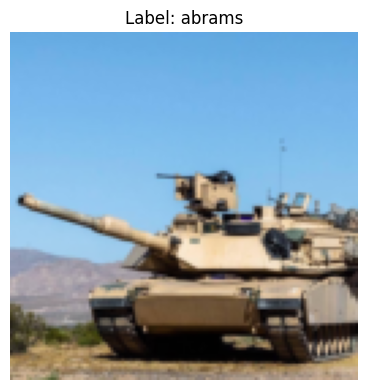

In [15]:
import os
import torch
from torchvision import transforms
from PIL import Image



#current_dir = os.path.dirname(os.path.abspath(__file__))
#current_dir = "Summer_practice_project/data/train"
#root = os.path.join(current_dir, '..', 'data', 'train')
#dataset = CustomImageDataset(current_dir, transform=None, target_size=(224, 224))
current_dir = os.getcwd()  # Текущая рабочая директория
root = os.path.join(current_dir,  'data', 'train')
root = "C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset/train"
dataset = CustomImageDataset(root, transform=None, target_size=(224, 224))
original_img, label = dataset[0]

class_names = dataset.get_class_names()
print(f"Оригинальное изображение, класс: {class_names[label]}")

show_image(original_img, class_names[label])

In [ ]:
import torch.nn.functional as F  # Импортируем функциональный модуль

class ModelNatoTanks(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=(1,1), stride=(1,1))
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=(2,2))
        self.BatchNorn_1 = nn.BatchNorm2d(num_features=16)

        self.conv_2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=(1,1), stride=(1,1))
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=(2,2))
        self.BatchNorn_2 = nn.BatchNorm2d(num_features=32)

        self.conv_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=(1,1), stride=(1,1))
        self.MaxPool_3 = nn.MaxPool2d(kernel_size=(2,2))
        self.BatchNorn_3 = nn.BatchNorm2d(num_features=32)

        self.conv_4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=(1,1), stride=(1,1))
        self.MaxPool_4 = nn.MaxPool2d(kernel_size=(2,2))
        self.BatchNorn_4 = nn.BatchNorm2d(num_features=32)

        self.conv_5 = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(3,3), padding=(1,1), stride=(1,1))
        self.MaxPool_5 = nn.MaxPool2d(kernel_size=(2,2))
        self.BatchNorn_5 = nn.BatchNorm2d(num_features=16)

        self.layer1 = nn.Linear(1024, 512)
        self.batch_1_fc = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512, 64)
        self.batch_2_fc = nn.BatchNorm1d(64)
        self.layer3 = nn.Linear(64, 3)
    
    def forward(self, x):
        #3*256*256
        x = self.conv_1(x)
        x = self.MaxPool_1(x)
        x = self.BatchNorn_1(x)
        x = F.relu(x)  # Используем F.relu вместо nn.ReLU
        #16*128*128

        x = self.conv_2(x)
        x = self.MaxPool_2(x)
        x = self.BatchNorn_2(x)
        x = F.relu(x)
        #32*64*64

        x = self.conv_3(x)
        x = self.MaxPool_3(x)
        x = self.BatchNorn_3(x)
        x = F.relu(x)
        #32*32*32

        x = self.conv_4(x)
        x = self.MaxPool_4(x)
        x = self.BatchNorn_4(x)
        x = F.relu(x)
        #32*16*16

        x = self.conv_5(x)
        x = self.MaxPool_5(x)
        x = self.BatchNorn_5(x)
        x = F.relu(x)
        #16*8*8

        x = x.flatten(start_dim=1)  # Используем x.flatten вместо nn.Flatten
        x = self.layer1(x)
        x = self.batch_1_fc(x)
        x = F.relu(x)  # ReLU после полносвязного слоя
        x = self.layer2(x)
        x = self.batch_2_fc(x)
        x = F.relu(x)  # ReLU после полносвязного слоя
        x = self.layer3(x)

        return x

In [38]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
BATCH_SIZE = 5
NUM_EPOCHS = 50
LEARNING_RATE = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(root_dir: str, model_save_path: str = "model.pth"):
    # Инициализация датасета и загрузчика данных
    train_dataset = CustomImageDataset(
        root_dir=root_dir,
        transform=transforms.Compose([transforms.ToTensor()]),
        target_size=(256, 256)
    )
    
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    # Инициализация модели
    model = ModelNatoTanks().to(DEVICE)
    
    # Функция потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Планировщик скорости обучения
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
    
    # Переменные для отслеживания лучшей модели
    best_loss = float('inf')
    best_accuracy = 0.0
    
    # Цикл обучения
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Прогресс-бар для эпохи
        progress_bar = tqdm(train_loader, desc=f"Эпоха {epoch+1}/{NUM_EPOCHS}")
        
        for images, labels in progress_bar:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            # Обнуление градиентов
            optimizer.zero_grad()
            
            # Прямой проход
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Обратное распространение и оптимизация
            loss.backward()
            optimizer.step()
            
            # Статистика
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Обновление прогресс-бара
            progress_bar.set_postfix({
                'loss': running_loss / total,
                'accuracy': 100. * correct / total
            })
        
        # Средние значения за эпоху
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = 100. * correct / total
        
        # Обновление планировщика
        scheduler.step(epoch_loss)
        
        # Сохранение лучшей модели
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Модель сохранена: {model_save_path} (loss: {epoch_loss:.4f})")
        
        # Логирование
        print(f"Эпоха {epoch+1}/{NUM_EPOCHS}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
    
    print("Обучение завершено!")
    return model


In [31]:
from torchvision import transforms

combined_aug = transforms.Compose([transforms.ToTensor()])

In [32]:
root = "C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset/train"
dataset = CustomImageDataset(root, transform=combined_aug, target_size=(256, 256))

In [ ]:
train_model(root_dir=root)

Эпоха 1/50:   0%|          | 0/209 [00:00<?, ?it/s]

c:\Users\artur\Desktop\SUMMER_PRACTICE_PROJECT\venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [6]:
import os
import re

def sanitize_filename(filename):
    # Удаляем недопустимые символы из имени папки
    invalid_chars = r'[\\\/:*?"<>|\[\]\-,]'
    sanitized = re.sub(invalid_chars, '_', filename)
    # Удаляем лишние пробелы и подчеркивания
    sanitized = re.sub(r'_+', '_', sanitized.strip())
    return sanitized

def rename_files_in_directory(directory):
    # Словарь для отслеживания порядковых номеров в каждой подпапке
    folder_counters = {}
    
    # Рекурсивно обходим все файлы и папки
    for root, dirs, files in os.walk(directory):
        # Получаем имя текущей подпапки
        folder_name = os.path.basename(root)
        # Очищаем имя подпапки
        sanitized_folder = sanitize_filename(folder_name)
        
        # Пропускаем корневую папку и папки, не соответствующие Abrams, Leopard или Challenger
        if sanitized_folder not in ['abrams', 'leopard', 'challenger']:
            continue
            
        # Инициализируем счетчик для текущей подпапки, если его нет
        if sanitized_folder not in folder_counters:
            folder_counters[sanitized_folder] = 0
        
        # Обрабатываем файлы в текущей подпапке
        for filename in files:
            # Увеличиваем счетчик для нового имени файла
            folder_counters[sanitized_folder] += 1
            # Формируем новое имя файла: имя_подпапки_номер.расширение
            file_extension = os.path.splitext(filename)[1]
            new_filename = f"{sanitized_folder}_{folder_counters[sanitized_folder]}{file_extension}"
            old_file_path = os.path.join(root, filename)
            new_file_path = os.path.join(root, new_filename)
            
            # Переименовываем файл
            try:
                os.rename(old_file_path, new_file_path)
                print(f"Переименован: {old_file_path} -> {new_filename}")
            except OSError as e:
                print(f"Ошибка при переименовании {old_file_path}: {e}")

if __name__ == "__main__":
    # Укажите путь к папке
    directory_path = "C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset"
    if os.path.exists(directory_path):
        rename_files_in_directory(directory_path)
        print("Обработка завершена.")
    else:
        print("Указанная папка не существует.")

Переименован: C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset\test\abrams\1024x768_173463_www.ArtFile.ru_.jpg -> abrams_1.jpg
Переименован: C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset\test\abrams\1445693030_m1a2sep_03.jpg -> abrams_2.jpg
Переименован: C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset\test\abrams\1693626457.jpg -> abrams_3.jpg
Переименован: C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset\test\abrams\20191016_143504.jpg -> abrams_4.jpg
Переименован: C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset\test\abrams\23326437_0_160_3073_1888_2072x0_60_0_0_f13e86cf7d917b6bfcb90edbe2742b9e.jpg -> abrams_5.jpg
Переименован: C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset\test\abrams\421c858c478f5fe72164bfbd7de6f4569881270d.jpeg -> abrams_6.jpeg
Переименован: C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset\test\abrams\44326824064_f969517b40_b.jpg -> abrams_7.jpg
Переименован: C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset\tes

In [ ]:
"C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/dataset"

In [11]:
class AugmentationPipeline:
    def __init__(self):
        self.augmentation = []
       
    def add_augmentations(self,name,aug):
        self.augmentation.append((name,aug))
    
    def remove_augmentation(self,name):
        for i in range(len(self.augmentation)):
            if self.augmentation[i][0] == name:
                del self.augmentation[i]
    
    def apply(self,image):
        augmentation_image = []
        for name, aug in self.augmentation:
            aug_img = aug(image)  # original_tensor: torch.Tensor [C, H, W]
            augmentation_image.append(aug_img)
        return augmentation_image
        
    def get_augmentations(self):
        return self.augmentation

In [9]:
from pathlib import Path
import os
from PIL import Image
from tqdm import tqdm

def apply_augmentations_to_dataset(input_dir='dataset/train',
                                  output_dir='results/train',
                                  augmentations_class=None):
    """
    Применяет аугментации ко всем изображениям в датасете и сохраняет результаты.
    
    Args:
        input_dir (str): Путь к исходной папке с данными
        output_dir (str): Путь для сохранения аугментированных данных
        augmentations_class (AugmentationPipeline): Объект с аугментациями для применения
    """
    
    # Создаем выходную директорию
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Получаем список классов
    classes = [d for d in os.listdir(input_dir) 
               if os.path.isdir(os.path.join(input_dir, d))]
    
    if not classes:
        print(f"В директории {input_dir} не найдено классов!")
        return
    
    # Обрабатываем каждый класс
    for class_name in tqdm(classes, desc="Обработка классов"):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        
        # Создаем директорию для класса
        Path(class_output_dir).mkdir(parents=True, exist_ok=True)
        
        # Получаем список изображений
        image_files = [f for f in os.listdir(class_input_dir) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        
        # Обрабатываем каждое изображение
        for image_file in tqdm(image_files, desc=f"Класс {class_name}", leave=False):
            image_path = os.path.join(class_input_dir, image_file)
            
            try:
                # Загружаем изображение
                img = Image.open(image_path)
                
                # Генерируем базовое имя файла (без расширения)
                base_name = os.path.splitext(image_file)[0]
                ext = os.path.splitext(image_file)[1].lower()
                
                # Применяем аугментации
                augmented_images = augmentations_class.apply(img)
                augmentation_names = augmentations_class.get_augmentations()

                # Сохраняем каждое аугментированное изображение
                for idx, aug_img in enumerate(augmented_images):
                    output_filename = f"{base_name}_aug{augmentation_names[idx][0]}{ext}"
                    output_path = os.path.join(class_output_dir, output_filename)
                    
                    # Сохраняем изображение
                    aug_img.save(output_path)
                
            except Exception as e:
                print(f"\nОшибка при обработке {image_path}: {e}")
                continue

In [20]:
class AddGaussianNoise:
    """Добавляет гауссов шум к изображению."""
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn_like(tensor) * self.std + self.mean


class RandomErasingCustom:
    """Случайно затирает прямоугольную область изображения."""
    def __init__(self, p=0.5, scale=(0.02, 0.2)):
        self.p = p
        self.scale = scale
    def __call__(self, img):
        if random.random() > self.p:
            return img
        c, h, w = img.shape
        area = h * w
        erase_area = random.uniform(*self.scale) * area
        erase_w = int(np.sqrt(erase_area))
        erase_h = int(erase_area // erase_w)
        x = random.randint(0, w - erase_w)
        y = random.randint(0, h - erase_h)
        img[:, y:y+erase_h, x:x+erase_w] = 0
        return img
class RandomPerspective:
    """Случайная перспективная трансформация"""
    def __init__(self, p=0.5, distortion_scale=0.5):
        self.p = p
        self.distortion_scale = distortion_scale
    
    def __call__(self, img):
        if random.random() < self.p:
            # Конвертируем тензор в PIL
            to_pil = transforms.ToPILImage()
            img_pil = to_pil(img)
            
            # Параметры перспективы
            w, h = img_pil.size
            half_w = w // 2
            half_h = h // 2
            
            # Генерируем случайные смещения
            dx = random.randint(0, int(self.distortion_scale * half_w))
            dy = random.randint(0, int(self.distortion_scale * half_h))
            
            # Точки для перспективной трансформации
            src_points = np.float32([[0, 0], [w, 0], [0, h], [w, h]])
            dst_points = np.float32([
                [dx, dy], 
                [w - dx, dy], 
                [0, h], 
                [w, h]
            ])
            
            # Применяем перспективную трансформацию
            M = cv2.getPerspectiveTransform(src_points, dst_points)
            img_np = np.array(img_pil)
            transformed = cv2.warpPerspective(img_np, M, (w, h))
            
            return transforms.ToTensor()(transformed)
        return img
class RandomBrightnessContrast:
    """Случайное изменение яркости и контрастности"""
    def __init__(self, p=0.5, brightness_range=(0.7, 1.3), contrast_range=(0.7, 1.3)):
        self.p = p
        self.brightness_range = brightness_range
        self.contrast_range = contrast_range
    
    def __call__(self, img):
        if random.random() < self.p:
            # Конвертируем тензор в PIL
            to_pil = transforms.ToPILImage()
            img_pil = to_pil(img)
            
            # Изменяем яркость
            brightness_factor = random.uniform(*self.brightness_range)
            enhancer = ImageEnhance.Brightness(img_pil)
            img_pil = enhancer.enhance(brightness_factor)
            
            # Изменяем контраст
            contrast_factor = random.uniform(*self.contrast_range)
            enhancer = ImageEnhance.Contrast(img_pil)
            img_pil = enhancer.enhance(contrast_factor)
            
            return transforms.ToTensor()(img_pil)
        return img
class CutOut:
    """Вырезает случайную прямоугольную область из изображения."""
    def __init__(self, p=0.5, size=(16, 16)):
        self.p = p
        self.size = size
    def __call__(self, img):
        if random.random() > self.p:
            return img
        c, h, w = img.shape
        cut_h, cut_w = self.size
        x = random.randint(0, w - cut_w)
        y = random.randint(0, h - cut_h)
        img[:, y:y+cut_h, x:x+cut_w] = 0
        return img



In [21]:
aug_medium = AugmentationPipeline()

aug_medium.add_augmentations("GaussianBlur", AddGaussianNoise())
aug_medium.add_augmentations("RandomPerspective", RandomPerspective())
aug_medium.add_augmentations("RandomErasingCustom", RandomErasingCustom(p=1.0))
aug_medium.add_augmentations("RandomBrightnessContrast", RandomBrightnessContrast())
aug_medium.add_augmentations("CutOut",CutOut())


In [23]:
apply_augmentations_to_dataset(augmentations_class =aug_medium,output_dir='dataset_augmentation/train',input_dir="C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train")

Обработка классов:  33%|███▎      | 1/3 [00:00<00:00,  5.96it/s]


Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Abrams\m1_abrams_l1.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Abrams\m1_abrams_l2.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Abrams\m1_abrams_l3.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Abrams\m1_abrams_l4.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Abrams\m1_abrams_l5.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Abrams\m1_abrams_main.jpg: name 'torch' is not defined



Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Challenger\challenger_2_l1.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Challenger\challenger_2_l10.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Challenger\challenger_2_l2.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Challenger\challenger_2_l3.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Challenger\challenger_2_l4.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Challenger\challenger_2_l5.jpg: name 'torch' is not defined

Ошибка при обр

Обработка классов: 100%|██████████| 3/3 [00:00<00:00, 15.54it/s]


Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Leopard\leopard_l1.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Leopard\leopard_l2.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Leopard\leopard_l3.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Leopard\leopard_l4.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Leopard\leopard_l5.jpg: name 'torch' is not defined

Ошибка при обработке C:/Users/artur/Desktop/SUMMER_PRACTICE_PROJECT/Summer_practice_project/data/train\Leopard\leopard_main.jpg: name 'torch' is not defined
